In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
from bilinear_interpolation import bilinear_interpolation
import xarray as xr
#import rioxarray as rio 

### Read dataframes 
> Climate data  
> Grid centres

In [27]:
src_path = r"W:/VUB/_main_research/data/RMI"
os.chdir(src_path)

# Read gridded meteo data with encoding ISO-8859-1 since utf-8 doesnt work (try other encodings e.g. latin1, cp1252)
try:
    clim_data = pd.read_csv("pdg1487.csv", sep=";", header=0, encoding="ISO-8859-1")
except UnicodeDecodeError as e:
    print("ISO-8859-1 didn't work: ", e)

#read 5km by 5km grid
grid = pd.read_csv(src_path+"/gridded_data_docu/grid 5x5km_def.csv", sep=" ", skiprows=1)

#### Transform coordinate system

In [28]:
# Define the transformer from WGS84 (EPSG:4326) to Belgian Lambert 1972 (EPSG:31370)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:31370")

# Function to transform coordinates
def transform_coords(lat, lon):
    return transformer.transform(lat, lon)

# Apply the transformation to each row in the DataFrame
grid['lambert72_x'], grid['lambert72_y'] = zip(*grid.apply(lambda row: transform_coords(row['LAT'], row['LON']), axis=1))

In [55]:
(grid.LAMBERT_X.max()-grid.LAMBERT_X.min())/5000,  (grid.LAMBERT_Y.max()-grid.LAMBERT_Y.min())/5000

(55.0, 44.0)

In [94]:
grid[grid.LON == grid.LON.min()]

,PIXEL_ID,LAMBERT_X,LAMBERT_Y,LAT,LON,lambert72_x,lambert72_y
1071,1072,-142500,6393014.18,51.069,2.514,20008.542846,197051.62075


##### (FYI Only): The transformation btn Lambert and EPSG4326

In [95]:
# Define the custom projection as source CRS (Lambert Conformal Conic). This comes from the data documentation.
proj_lcc = "+proj=lcc +lat_2=50.56989865 +lat_1=50.56989865 +lon_0=4.55361516 +units=m +no_defs +a=6371229.0 +es=0.0"

# Target CRS (WGS84 lat/lon)
proj_wgs84 = "EPSG:4326"

# Initialize the transformer
transformer = Transformer.from_crs(proj_lcc, proj_wgs84, always_xy=True)

# Example coordinates in Lambert Conformal Conic (x, y)
x,y = -142500,	6393014.18

# Transform coordinates to lat/lon
lon, lat = transformer.transform(x, y)
print(f"Longitude: {lon}, Latitude: {lat}")

Longitude: 2.5140822063438204, Latitude: 51.069365425809515


##### Merge climate data with coordinate grid

In [57]:
#merge the two dataframes on pixel_id
climate_data_df = clim_data.merge(grid, on='PIXEL_ID')

#set date and pixel_id as index
climate_data_df.set_index(['DATE', 'PIXEL_ID'], inplace=True)

#sort the index
climate_data_df.sort_index(inplace=True)

#rename the columns to lower case
climate_data_df.columns = climate_data_df.columns.str.lower()

#calculate the mean temperature
#climate_data_df['mean_daily_temperature']=0.5*(climate_data_df['temperature min (°c)'] + climate_data_df['temperature max (°c)'])

#extract climate variable names from the dataframe columns
climate_variables=['max_daily_temperature', 'min_daily_temperature', 'precipitation', 'Potential_evapotranspiration', 'global_radiation', 'wind_speed']

In [58]:
# Replace column names from index 2 to 8 (clim variables)
subset_columns = list(climate_data_df.columns[2:8])
new_names_dict = dict(zip(subset_columns, climate_variables))

# Rename the subset of columns
climate_data_df.rename(columns=new_names_dict, inplace=True)

In [59]:
climate_data_df["1994-01-01":"1994-01-01"]

pixel_lon_center  pixel_lat_center  \
DATE       PIXEL_ID                                       
1994-01-01 1                 5.419101         49.510015   
           2                 5.488333         49.509469   
           3                 5.557563         49.508882   
           4                 5.626792         49.508253   
           5                 5.419910         49.554969   
...                               ...               ...   
           1356              4.517511         51.491625   
           1357              4.734134         51.491493   
           1358              4.806341         51.491362   
           1359              5.022959         51.490706   
           1360              5.095163         51.490399   

                     max_daily_temperature  min_daily_temperature  \
DATE       PIXEL_ID                                                 
1994-01-01 1                           4.1                    2.3   
           2                           3.3                    2.4   
           3                           2.5                    2.4   
           4                           2.7                    2.2   
           5                           3.3                    2.2   
...                                    ...                    ...   
           1356                        4.7                    0.8   
           1357                        4.9                    1.0   
           1358                        4.8                    1.0   
           1359                        4.7                    1.2   
           1360                        4.7                    1.3   

                     precipitation  Potential_evapotranspiration  \
DATE       PIXEL_ID                                                
1994-01-01 1                  10.4                           0.4   
           2                  10.0                           0.4   
           3                   9.6                           0.4   
           4                   9.7                           0.4   
           5                  10.3                           0.4   
...                            ...                           ...   
           1356                9.5                           0.4   
           1357                9.8                           0.4   
           1358                9.5                           0.4   
           1359                8.1                           0.3   
           1360                7.9                           0.3   

                     global_radiation  wind_speed  lambert_x   lambert_y  \
DATE       PIXEL_ID                                                        
1994-01-01 1                     0.37         4.9      62500  6218014.18   
           2                     0.34         4.9      67500  6218014.18   
           3                     0.34         4.9      72500  6218014.18   
           4                     0.40         4.9      77500  6218014.18   
           5                     0.38         4.9      62500  6223014.18   
...                               ...         ...        ...         ...   
           1356                  0.59         4.5      -2500  6438014.18   
           1357                  0.61         4.4      12500  6438014.18   
           1358                  0.60         4.4      17500  6438014.18   
           1359                  0.65         4.4      32500  6438014.18   
           1360                  0.63         4.3      37500  6438014.18   

                        lat    lon    lambert72_x    lambert72_y  
DATE       PIXEL_ID                                               
1994-01-01 1         49.510  5.419  226066.415779   22556.879670  
           2         49.509  5.488  231065.107850   22518.715067  
           3         49.509  5.558  236134.576126   22597.572678  
           4         49.508  5.627  241133.434307   22568.767442  
           5         49.555  5.420  226067.928965   27562.717350  
...         

#### Correct projected coordinates
>The projected coordinates do not form an aligned grid i.e the step sizes are not exactly equal to the resolution of the dataset (5000).  
>Here is how they are aligned: from each grid value, the min x and y (lowest left corner of the grid) are subtracted and then the difference rounded off to the nearest 5000. This rounded difference is then added to the min x and y values.

In [31]:
#extract the minimum and maximum values of the x and y coordinates
min_x, min_y=climate_data_df["1994-01-01":"1994-01-01"]['lambert72_x'].min(), climate_data_df["1994-01-01":"1994-01-01"]['lambert72_y'].min()

#these coordinates are slightly off the  centre of the grid. Hard code it using  values from QGIS
min_x_corr, min_y_corr= 20008.54285,22518.71507
max_x_corr, max_y_corr= 296031.0126,242580.5328

#calculate deviation from the minimum values as absolute values
# climate_data_df['lambert72_x']-=min_x_corr 
# climate_data_df['lambert72_y']-=min_y_corr

#calculate the deviation of lambert72_x and lambert72_y from the maximum values
climate_data_df['lambert72_x']=max_x_corr-climate_data_df['lambert72_x']
climate_data_df['lambert72_y']=max_y_corr-climate_data_df['lambert72_y']

# #round the x and y coordinates to the nearest gridsize (5000)
climate_data_df['lambert72_x']=abs(climate_data_df['lambert72_x']//5000)*5000 #abs is used to round negative numbers to the nearest 5000
climate_data_df['lambert72_y']=abs(climate_data_df['lambert72_y']//5000)*5000

# # #add the rounded x and y coordinates to the minimum values
climate_data_df['lambert72_x']=max_x_corr-climate_data_df['lambert72_x']
climate_data_df['lambert72_y']=max_y_corr-climate_data_df['lambert72_y']

In [8]:
min_x,min_x_corr, min_y_corr

(20008.542846339362, 20008.54285, 22518.71507)

In [9]:
(climate_data_df['lambert72_x'].min(),climate_data_df['lambert72_x'].max())

(21031.012600000016, 296031.0126)

In [10]:
climate_data_df['lambert72_x'].min()

21031.012600000016

In [11]:
(climate_data_df['lambert72_y'].min(),climate_data_df['lambert72_y'].max())

(22580.532799999986, 242580.5328)

### Transform dataframe to gridded data

In [12]:
#STEPS
# create a date list..
#create a pivot table corresponding to each date..
#convert the data to a numpy array
#convert the array to a xarray dataset
#store the xarray datasets in a list and then concatenate them along the time dimension
#save the xarray dataset to a netcdf file

#### Generate Gridded data using Lambert coordinates

In [60]:
#gridded values
# Calculate step sizes based on resolution of the dataset
x_step = 5000  # Step size for x_in
y_step = 5000  # Step size for y_in

# Define input data grid, the grid defines the center of the pixels (somehow I am amazed by this. I supposed the grid would have needed to be shifted by half the pixel size to align with the pixel edges)
#I plotted this data on QGIS and it seems to be correct. The grid is aligned with the pixel centers.

x_in = np.arange(climate_data_df["lambert_x"].min(), climate_data_df["lambert_x"].max() + x_step, x_step) #np.arange is exclusive of the stop value so need to half the additional to the max values.
y_in = np.arange(climate_data_df["lambert_y"].min(), climate_data_df["lambert_y"].max() + y_step, y_step)

#create a date list and calculate length of data using the date index (level 0)
start_date = climate_data_df.index.levels[0][0]
len_data=len(climate_data_df.index.levels[0])
date_list = pd.date_range(start=start_date, periods=len_data, freq='D')
units=['°C', '°C', 'mm', 'mm', 'kWh/m2/day', 'm/s', '°C']

dataset_list = []

# Loop through the climate variables and their corresponding units
for variable, unit in zip(climate_variables, units):
    
    x_array_list = [] # List to store daily DataArrays
    for date, data in climate_data_df.groupby(level=0):
        #select the coordinates and convert to an np array
        data_grid=data.pivot_table(index='lambert_y', columns='lambert_x', values=variable)

        # Convert the grid to xarray DataArray using -1 aligns the values with the pixel edges up the second to last value
        daily_data_array = xr.DataArray(data_grid, coords=[y_in, x_in], dims=['lat', 'lon'])

        #data type as float32
        daily_data_array.astype(np.float32)

        # Append the DataArray to the list
        x_array_list.append(daily_data_array)

    # Concatenate the DataArrays along the time dimension
    x_data_array = xr.concat(x_array_list, dim='time')

    # Add the date list as a coordinate
    x_data_array['time'] = date_list
    x_data_array.name = variable

    #transform to a dataset
    dataset = x_data_array.to_dataset(name=variable)
    x_data_array.attrs['units'] = unit
    x_data_array.attrs['long_name'] = variable
    x_data_array.attrs['crs'] = 'EPSG:31370'
    x_data_array.attrs['history'] = f'created by {os.getlogin()} on {pd.Timestamp.now()}'

    # Append the DataArray to the list
    dataset_list.append(dataset)

##### Option 1: Assign BL72 coordinates (non-negative)

In [ ]:
# Define input data grid. the data seems to be in the same grid so we can use the same x and y values without recalculating the edges.
#The grids are shifted to fit the pixel edges by default.
x_in_corrected = np.arange(climate_data_df["lambert72_x"].min(), climate_data_df["lambert72_x"].max()+x_step, x_step)-430 #430 is the average difference between the raw projections and the projections rounded off to the nearest 5000
y_in_corrected = np.arange(climate_data_df["lambert72_y"].min(), climate_data_df["lambert72_y"].max()+y_step, y_step)-128.6 #same as above. This pushes the grid to the left and up to align with the pixel edges


for dataset,unit in zip(dataset_list,units):
    #assign the lambert72_x and lambert72_y coordinates
    dataset['lat'] = y_in_corrected
    dataset['lon'] = x_in_corrected
    #assign the crs
    dataset.attrs['crs'] = 'EPSG:31370'
    dataset.attrs['units'] = unit
    dataset.attrs['history'] = f'created by {os.getlogin()} on {pd.Timestamp.now()}'

#### Reproject to EPSG 4326 with rioxarray

In [ ]:
#https://stackoverflow.com/questions/54956948/gdal-reprojecting-netcdf-file

ds = xr.open_dataset(r"W:\VUB\_main_research\data\RMI\climate_data_5km.nc")

ds.rio.write_crs("EPSG:31370", inplace=True)
ds = ds.rename({"lon": "x", "lat": "y"})
dsp=ds.rio.reproject("EPSG:4326")

In [303]:
#calculate tavg
dsp['tavg'] = 0.5*(dsp['min_daily_temperature'] + dsp['max_daily_temperature'])
#rename the variables
dsp_data = dsp.rename_vars({'max_daily_temperature': 'tmax', 'min_daily_temperature': 'tmin', 
                       'precipitation': 'prec', 'Potential_evapotranspiration': 'pet',
                         'global_radiation': 'rad', 'wind_speed': 'wind'})
#rename the coordinates
dsp_data = dsp_data.rename({'x': 'lon', 'y': 'lat'})
dsp_data.attrs['units'] = 'standard units'

In [ ]:
#export each variable to a netcdf file
vars = ['tmax', 'tmin', 'tavg', 'prec', 'pet']

for var in vars:
    dsp_data[var].to_netcdf(f"W:/VUB/_main_research/data/RMI/RMI_{var}.nc")

#### Resample data spatially

In [330]:
#resolution of the data
input_resolution = dsp_data.lon.values[1]-dsp_data.lon.values[0]

In [342]:
output_grid_resolution = 0.03125
input_resolution = 0.06168531473066752

weight = (output_grid_resolution / input_resolution)

# Create target grid explicitly
target_lon = np.arange(lon.min(), lon.max(), output_grid_resolution)
target_lat = np.arange(lat.min(), lat.max(), output_grid_resolution)

# Interpolate data to the target grid
ds_resampled = dsp_data.interp(lon=target_lon, lat=target_lat, method="linear")

#### Use xesmf

### Assign time 

In [ ]:
# Define start and end dates
start_date = np.datetime64('1950-01-01')
end_date = np.datetime64('2023-12-31')

# Generate an array of days
days = np.arange(start_date, end_date + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Add the fixed time component '23:00:00' and cast to datetime64[ns]
time_array = (days + np.timedelta64(23, 'h')).astype('datetime64[ns]')

# Print the result
print(time_array)

### Export dataset as netCDF

In [255]:
#save the dataset to a netcdf file
merged_dataset=xr.merge(dataset_list)

# Print all keys to verify the existence of the required key
print("Available keys in merged_dataset:")
print(list(merged_dataset.data_vars))

#merged_dataset.to_netcdf("W:/VUB/main_research/data/RMI/climate_data_5km.nc")

Available keys in merged_dataset:
['max_daily_temperature', 'min_daily_temperature', 'precipitation', 'Potential_evapotranspiration', 'global_radiation', 'wind_speed']


In [256]:
merged_dataset

<xarray.Dataset>
Dimensions:                       (lat: 45, lon: 56, time: 11044)
Coordinates:
  * lat                           (lat) float64 6.218e+06 ... 6.438e+06
  * lon                           (lon) int32 -142500 -137500 ... 127500 132500
  * time                          (time) datetime64[ns] 1994-01-01 ... 2024-0...
Data variables:
    max_daily_temperature         (time, lat, lon) float64 nan nan ... nan nan
    min_daily_temperature         (time, lat, lon) float64 nan nan ... nan nan
    precipitation                 (time, lat, lon) float64 nan nan ... nan nan
    Potential_evapotranspiration  (time, lat, lon) float64 nan nan ... nan nan
    global_radiation              (time, lat, lon) float64 nan nan ... nan nan
    wind_speed                    (time, lat, lon) float64 nan nan ... nan nan

#### Export point csv

In [53]:
#Boechout
x,y=161367.1,206609.1

#extract each variable from the dataset
variables=list(merged_dataset.data_vars)
#extract the data for Boechout
df_list=[]
for variable in variables:
    data=merged_dataset[variable].sel(lat=y, lon=x, method='nearest')
    data_df= data.to_dataframe().drop(columns=['lat', 'lon'])
    df_list.append(data_df)

#concatenate the dataframes
boechout_climate_data_df=pd.concat(df_list, axis=1)
boechout_climate_data_df.to_csv(f"W:/VUB/main_research/data/RMI/boechout_climate_data.csv")

#### Write data to GeoTiff

In [15]:
bT = dataset['mean_daily_temperature']
bT.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
bT.rio.crs
#set the crs
bT.rio.write_crs("EPSG:31370", inplace=True)

#set number of bands
bT.rio.to_raster(r"mean_temp_corrected_centred.tif", compress='LZW', dtype='float32')

#### Check if points are correctly mapped

In [ ]:
#search for a value at specific index   and check if the value is the same as the one in the dataframe
# Define the coordinates of the point of interest
x_point, y_point = 72500, 6218014.18

data_grid.columns.get_loc(x_point) #last variable in the loop
data_grid.index.get_loc(y_point)

data_grid.loc[y_point, x_point]
 #check if the value is the same as the one in the dataframe
# Filter the DataFrame for the specific latitude and longitude
df=climate_data_df.tail(1360) #select the last 1360 rows (values for the last date)

result = df[(df['lambert_x'] == x_point) & (df['lambert_y'] == y_point)]['wind speed (m/s)'].values[0]
result, data_grid.loc[y_point, x_point]

#### (Optional) Bilinear interpolation

In [ ]:
# For the interpolated output grid, more refined
"""

x_out_step = 2000  # Step for output grid
y_out_step = 2000

x_out = np.arange(x_in.min(),x_in.max()+x_out_step, x_out_step) #end exclusive
y_out = np.arange(y_in.max(),y_in.min()-y_out_step, -y_out_step) #reverse the y_out array to start from the top and - y_out_step to go down. End EXCLUSIVE

# Ensure f_in is the grid of values
f_in =data_grid.to_numpy()

# Ensure bilinear_interpolation is defined to handle this grid setup correctly
f_out = bilinear_interpolation(x_in, y_in, f_in, x_out, y_out)

"""

In [39]:
ds = xr.open_dataset(r"W:\VUB\_main_research\data\RMI\climate_data_5km.nc")

In [42]:
# Define the transformer from WGS84 (EPSG:4326) to Belgian Lambert 72 (EPSG:31370)
transformer = Transformer.from_crs("EPSG:31370","EPSG:4326", always_xy=True)


# Step 1: Create a meshgrid of lat and lon coordinates
lon_grid, lat_grid = np.meshgrid(ds['lon'], ds['lat'])

# Step 2: Transform the coordinates from EPSG:4326 to EPSG:31370
lon1, lat1 = transformer.transform(lon_grid, lat_grid)

# Step 3: Assign the transformed coordinates back to the dataset
ds = ds.assign_coords({
    "lon1": (["lat", "lon"], lon1),
    "lat1": (["lat", "lon"], lat1)
})

# Step 4: Optional - Drop old lat/lon if not needed
ds = ds.drop_vars(["lat", "lon"])


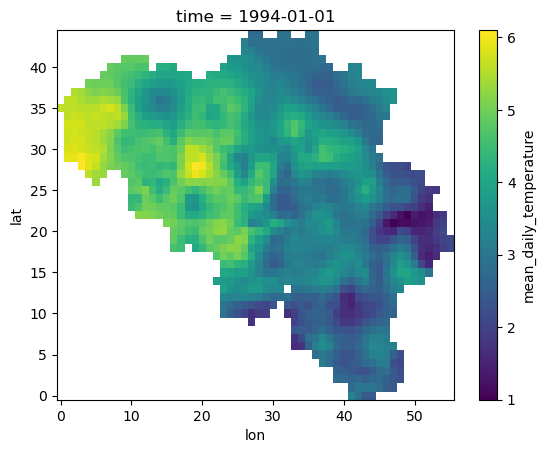

In [45]:
ds['mean_daily_temperature'][0].plot()